### Imports

In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
import umap

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
import seaborn as sns

In [3]:
from sklearn.cluster import KMeans

In [4]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import numpy as np

In [5]:
from sklearn import metrics

In [ ]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score

In [ ]:
import shap
shap.initjs()

### Config

In [6]:
# pandas 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# matplotlib
plt.rcParams['figure.figsize'] = [12.0, 10.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 'large'
plt.rcParams['figure.titlesize'] = 'medium'

### Functions

In [7]:
def plot_predictions(y_true, y_pred, uncertainty, y_label, **kwargs):
    fig = plt.figure(figsize=(8, 7))
    ax = plt.gca()
    
    minval, maxval = np.min(y_true), np.max(y_true)
    minval = minval - 0.01 * minval
    maxval = maxval + 0.01 * maxval
    ax.set_xlim(minval, maxval)
    ax.set_ylim(ax.get_xlim())
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="b", label='Perfect prediction')
    if 'cmap' not in kwargs:
        kwargs.update({'cmap': 'coolwarm'})
    sc = ax.scatter(y_pred, y_true, c=uncertainty, **kwargs)
    ax.set_ylabel('y_true')
    ax.set_xlabel('y_pred')
             
    text_metrics = r'$R^2$={:.2f}'.format(metrics.r2_score(y_true, y_pred))

    ax.set_title('\n'.join([y_label, text_metrics]))
    cbar = plt.colorbar(sc)
    cbar.set_label('Uncertainty')
    plt.legend()

In [8]:
def get_model_importances(models):
    df_importance = models[0].get_feature_importance(prettified=True)

    for m in models[1:]:
        df_importance['Importances'] += m.get_feature_importance(prettified=True)['Importances']
    return df_importance

In [ ]:
def beta_score(mu, std, y_true, threshold = 0.015):
    a_range = (y_true.values - threshold*y_true.values, y_true.values + threshold*y_true.values)
    betas = []
    for i in range(len(mu)):
        mu_i, std_i = mu[i], std[i]
        normal = np.random.normal(mu_i, std_i, 1000)
        beta_i = np.where(np.logical_and(a_range[0][i]<=normal, normal<=a_range[1][i]))[0].shape[0] / 1000
        betas.append(beta_i)
    return np.mean(betas, axis=0)
    
def a_accuracy(y_true, y_hat, threshold = 0.015):
    a_range = (y_true.values - threshold*y_true.values, y_true.values + threshold*y_true.values)
    return np.where(np.logical_and(a_range[0]<=y_hat, y_hat<=a_range[1]))[0].shape[0]/(y_hat.shape[0])

def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Perceantage Error between two arrays.
    '''
    eps = 1e-10
    loss = np.sqrt(np.mean(np.square(((y_true - y_pred) / (y_true+eps)))))
    return loss #output in %

def c_score(y_true, y_hat):
    std = np.std(y_true)
    return np.where((np.abs(y_hat - y_true)) < 2*std)[0].shape[0] / y_hat.shape[0]

# Battery SoC data

### Load data

In [9]:
fname = 'dataset_training.csv'
data_folder = os.path.join(os.getcwd(), 'Data')
fpath = os.path.join(data_folder, fname)

In [10]:
df = pd.read_csv(fpath)
df.drop("Unnamed: 0", axis=1,inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 19 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Capacity dV CCCT                     226 non-null    float64
 1   Charge time dV CCCT                  226 non-null    float64
 2   Coefficient of skewness CCCV         226 non-null    float64
 3   Discharge_Q                          226 non-null    float64
 4   Energy dV CCCT                       226 non-null    float64
 5   Entropy dV CCCT                      226 non-null    float64
 6   Entropy dV CCCT Shannon              226 non-null    float64
 7   Frechet Distance CC curve            226 non-null    float64
 8   Group                                226 non-null    float64
 9   Hausdorff Distance CC curve          226 non-null    float64
 10  Kurtosis coefficient CCCV            226 non-null    float64
 11  Lagged Cumulated Discharge Capac

In [35]:
target = 'SOH_discharge_capacity'

In [12]:
df.describe()

,Capacity dV CCCT,Charge time dV CCCT,Coefficient of skewness CCCV,Discharge_Q,Energy dV CCCT,Entropy dV CCCT,Entropy dV CCCT Shannon,Frechet Distance CC curve,Group,Hausdorff Distance CC curve,Kurtosis coefficient CCCV,Lagged Cumulated Discharge Capacity,Lagged Cumulated Discharge Energy,Lagged Pseudo Resistace,Lagged cycle time,Mean DV CCCV,Recovery Voltage,SOH_discharge_capacity,Slope CCCV-CCCT
count,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000,226.000000
mean,466.460573,0.005001,0.019940,629.283862,466.460573,0.128834,8.686714,0.846935,8001.991150,6.567651,0.138931,24532.691023,77149.779967,0.030273,2.725632,0.467713,2.700012,0.854546,18.038105
std,54.318763,0.000163,0.003022,52.370821,54.318763,0.001414,0.045151,0.000054,0.827264,0.109412,0.003607,13728.803921,43222.431513,0.013420,1.523909,0.004306,0.000132,0.071166,0.591251
min,349.596523,0.004688,0.009693,501.435046,349.596523,0.125276,8.566054,0.846828,8001.000000,6.351351,0.126383,0.000000,0.000000,0.000000,0.000000,0.461268,2.699652,0.682393,16.954704
25%,417.144023,0.004861,0.019321,581.162332,417.144023,0.127928,8.654636,0.846890,8001.000000,6.486733,0.137573,12838.808136,40298.046816,0.021498,1.427159,0.464679,2.699927,0.790384,17.584214
50%,462.999395,0.005046,0.020104,622.707867,462.999395,0.128640,8.695227,0.846952,8002.000000,6.603932,0.139027,25019.910089,78680.436057,0.027257,2.776600,0.466974,2.700013,0.845835,17.854424
75%,509.093935,0.005127,0.022097,669.863374,509.093935,0.129737,8.723660,0.846977,8003.000000,6.644031,0.141176,36354.897608,114501.658021,0.035446,4.048363,0.468735,2.700105,0.909824,18.532200
max,578.290452,0.005313,0.024151,739.110921,578.290452,0.133564,8.791163,0.847032,8003.000000,6.774395,0.145682,48494.177843,152910.711527,0.129244,5.360378,0.482614,2.700457,1.000000,19.210952


In [63]:
df.corr()['SOH_discharge_capacity']

Capacity dV CCCT                       0.997850
Charge time dV CCCT                   -0.798468
Coefficient of skewness CCCV          -0.375940
Discharge_Q                            0.999480
Energy dV CCCT                         0.997850
Entropy dV CCCT                       -0.227929
Entropy dV CCCT Shannon               -0.747791
Frechet Distance CC curve             -0.801084
Group                                  0.065252
Hausdorff Distance CC curve           -0.790718
Kurtosis coefficient CCCV             -0.250027
Lagged Cumulated Discharge Capacity   -0.980501
Lagged Cumulated Discharge Energy     -0.980395
Lagged Pseudo Resistace               -0.772217
Lagged cycle time                     -0.982013
Mean DV CCCV                           0.424378
Recovery Voltage                      -0.018573
SOH_discharge_capacity                 1.000000
Slope CCCV-CCCT                        0.803668
Name: SOH_discharge_capacity, dtype: float64

In [36]:
drop_cols = ['Capacity dV CCCT', 'Energy dV CCCT', 'Lagged Cumulated Discharge Capacity', 
             'Lagged Cumulated Discharge Energy', 'SOH_discharge_capacity', 'Lagged cycle time', 'Discharge_Q']

In [14]:
le = preprocessing.LabelEncoder()
le.fit(df.Group.unique().tolist())
le.classes_
df['le_group'] = le.transform(df.Group)

In [37]:
X = df.loc[:, [col for col in df.columns.tolist() if col != target and col not in drop_cols]]

In [38]:
y = df.loc[:, [target]]

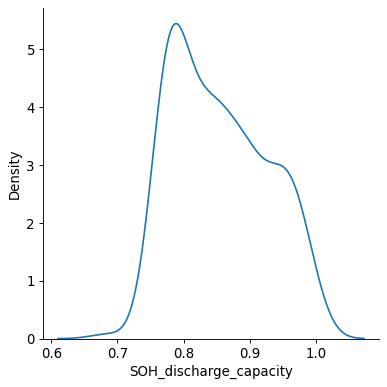

In [39]:
sns.displot(data=df, x=target, kind="kde", palette='Paired')

In [40]:
X = StandardScaler().fit_transform(X)

In [41]:
reducer = umap.UMAP()

In [42]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=2,
    random_state=42,
).fit_transform(X)

In [43]:
clusterable_embedding.shape

(226, 2)

In [44]:
df['y1'] = clusterable_embedding[:,0]
df['y2'] = clusterable_embedding[:,1]

In [47]:
df['SOH_discharge_capacity'].std()/df['SOH_discharge_capacity'].mean()

0.08327883009762291

In [52]:
plt.rc('axes', labelsize=20)
plt.rcParams['font.size'] = 16

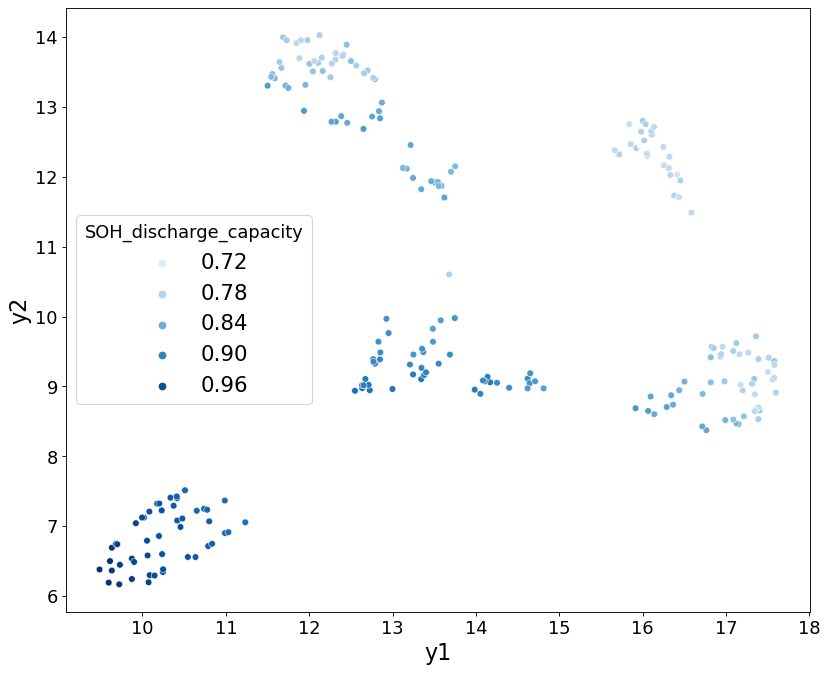

In [53]:
sns.scatterplot(data=df, x="y1", y="y2", hue='SOH_discharge_capacity', palette='Blues')
plt.savefig('toydata_umap.jpeg')

## Train a catboost regressor

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, [col for col in df.columns.tolist() if col != target and col not in drop_cols]], df[target], test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)                                                  

In [28]:
# model Params
loss_fn = 'RMSEWithUncertainty'
SEED = 4711

params = {
    'loss_function': loss_fn,
    'eval_metric': 'RMSE',
    'verbose': 100,
    'random_seed': SEED,
    #'cat_features': cat_features,
    'early_stopping_rounds': 300,
    # 'l2_leaf_reg': 0.1,
    # 'learning_rate': 0.01,
    # 'posterior_sampling': True,
}

In [63]:
# cross validate
scores = []
models = []

k = 5 # amount of data folds
all_predictions = np.zeros((k, X_test.shape[0]))

folds = KFold(n_splits=k, shuffle=True, random_state=SEED)

params.update({'loss_function': 'RMSE'})

for fold_n, (train_index, valid_index) in enumerate(folds.split(X_train, y_train)):
    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[valid_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[valid_index]
    
    #X_train_pool = Pool(data=X_train_fold, label=y_train_fold,
    #                    cat_features=cat_features)
    #X_valid_pool = Pool(data=X_valid_fold, label=y_valid_fold,
    #                    cat_features=cat_features)
    
    model = CatBoostRegressor(**params)
    model.fit(X_train_fold, y_train_fold,
              eval_set=(X_valid_fold, y_valid_fold), 
              use_best_model=True)
    models.append(model)

    score = model.get_best_score()['validation'][params['loss_function']]
    scores.append(score)

    y_pred = model.predict(X_test)
    all_predictions[fold_n] = y_pred

#prediction = all_predictions.mean(axis=0) * 1.0/scores.std(axis=0)
#prediction /= k
print('CV mean: {:.4f}, CV std: {:.4f}'.format(np.mean(scores), np.std(scores)))

Learning rate set to 0.030617
0:	learn: 51.9503630	test: 44.0659680	best: 44.0659680 (0)	total: 2.02ms	remaining: 2.02s
100:	learn: 10.7314830	test: 9.7769970	best: 9.7769970 (100)	total: 67.2ms	remaining: 598ms
200:	learn: 5.3745506	test: 6.6502842	best: 6.6502842 (200)	total: 129ms	remaining: 512ms
300:	learn: 3.3191666	test: 6.3267629	best: 6.2905482 (283)	total: 196ms	remaining: 455ms
400:	learn: 2.1613820	test: 6.4180105	best: 6.2905482 (283)	total: 261ms	remaining: 390ms
500:	learn: 1.5079249	test: 6.4118110	best: 6.2905482 (283)	total: 320ms	remaining: 318ms
Stopped by overfitting detector  (300 iterations wait)

bestTest = 6.290548196
bestIteration = 283

Shrink model to first 284 iterations.
Learning rate set to 0.030617
0:	learn: 50.0719713	test: 52.0155016	best: 52.0155016 (0)	total: 1.08ms	remaining: 1.08s
100:	learn: 10.2337799	test: 12.7929303	best: 12.7929303 (100)	total: 59.1ms	remaining: 526ms
200:	learn: 5.0812810	test: 9.6641919	best: 9.6641919 (200)	total: 112ms	rem

### Evaluation

In [78]:
y_hat = np.mean(all_predictions, axis=0)
std = np.std(all_predictions, axis=0)

In [83]:
mape_cb = metrics.mean_absolute_percentage_error(y_test, y_hat)
rmspe_cb = rmspe(y_test,y_hat)
r2_cb = r2_score(y_test, y_hat)
sharpness_cb = (np.mean(np.std(all_predictions, axis=0)) / np.mean(y_test, axis=0))
c_score_cb = c_score(y_test, y_hat)
beta_score_cb = beta_score(y_hat, std, y_test, 0.015)
a_acc_cb = a_accuracy(y_test, y_hat, 0.015)

In [55]:
idx = pd.MultiIndex.from_product([['cb'],
                                  ['cap']],
                                 names=['model', 'target'])
col = ['mape', 'rmspe', 'c_score', 'sharpness', 'a_acc', 'beta', 'R2']

comp = pd.DataFrame(np.nan, idx, col)
comp

,,mape,rmspe,c_score,sharpness,a_acc,beta,R2
model,target,,,,,,,
cb,cap,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [85]:
model_name = 'cb'
target_name = 'cap'
comp.loc[(model_name, target_name), ['mape']] = mape_cb
comp.loc[(model_name, target_name), ['rmspe']] = rmspe_cb
comp.loc[(model_name, target_name), ['c_score']] = c_score_cb
comp.loc[(model_name, target_name), ['sharpness']] = sharpness_cb
comp.loc[(model_name, target_name), ['beta']] = beta_score_cb
comp.loc[(model_name, target_name), ['a_acc']] = a_acc_cb
comp.loc[(model_name, target_name), ['R2']] = r2_cb

In [59]:
comp.round(3)

,,mape,rmspe,c_score,sharpness,a_acc,beta,R2
model,target,,,,,,,
cb,cap,1.245,3.44,1.0,0.003,0.826,0.832,0.911


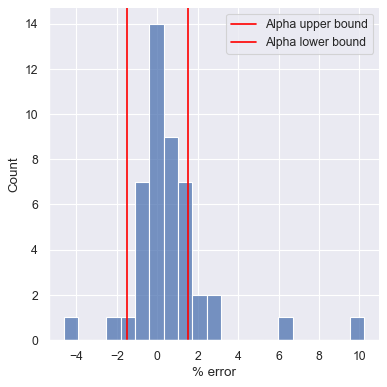

In [93]:
plt.rcParams['figure.figsize'] = [12.0, 10.0]
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 100
sns.set(rc={'figure.figsize':(16,10)})
errs = ((y_test - y_hat)/y_test)*100
g = sns.displot(data=errs)
plt.axvline(1.5, 0,1, label='Alpha upper bound', c='red')
plt.axvline(-1.5, 0,1, label = 'Alpha lower bound', c='red')
#plt.axvline(np.mean(errs), 0,1, label = 'Mean', c='green')
plt.xlabel('% error')
#g.set(xticklabels=['tja'])
plt.legend(loc='best')
plt.savefig('err_toy.jpeg')